In [12]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
df = pd.read_csv('oceanographic and meteorological dataset.csv')

In [14]:
def add_direction_features(df, col):
    df[f'{col}_sin'] = np.sin(np.deg2rad(df[col]))
    df[f'{col}_cos'] = np.cos(np.deg2rad(df[col]))
    return df
df = add_direction_features(df, 'mwd_era5')
df = add_direction_features(df, 'mwd_cop')
df.describe()

,u10_era5,v10_era5,mwd_era5,mwp_era5,swh_era5,pp1d_era5,uo_cop,vo_cop,swh_cop,mwp_cop,mwd_cop,peak_period_cop,mwd_era5_sin,mwd_era5_cos,mwd_cop_sin,mwd_cop_cos
count,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,2184.000000,2184.000000,2184.000000,2184.000000,7993.000000,7993.000000,2184.000000,2184.000000
mean,2.188604,-0.618673,254.533087,8.491293,2.289455,10.429202,-0.005831,-0.023458,2.396094,6.664016,260.916772,10.912761,-0.482059,0.436709,-0.450800,0.459881
std,5.049941,5.654880,101.285307,1.508553,1.293055,2.219554,0.108640,0.109127,1.456047,1.374168,99.155991,2.368424,0.585773,0.483577,0.589320,0.488117
min,-10.217163,-17.162354,0.005922,5.044391,0.706308,4.360695,-0.462891,-0.603516,0.620000,3.730000,0.030000,4.760000,-1.000000,-0.999988,-1.000000,-0.999941
25%,-1.410156,-4.420624,247.110920,7.368544,1.306941,8.810890,-0.082031,-0.090820,1.310000,5.590000,255.900000,9.130000,-0.926656,0.149474,-0.924246,0.172230
50%,2.046631,-1.186233,291.861820,8.303400,1.870715,10.276711,-0.007812,-0.026367,1.860000,6.530000,294.380000,10.680000,-0.712566,0.533409,-0.667248,0.563454
75%,5.630310,3.352921,320.586180,9.305229,2.910931,11.903175,0.063477,0.043945,3.110000,7.620000,326.745000,12.432500,-0.268729,0.849137,-0.197144,0.891224
max,21.640991,17.548920,359.915250,14.556703,8.823090,19.234710,0.558594,0.473633,9.290000,11.420000,359.920000,20.010000,1.000000,1.000000,1.000000,1.000000


In [15]:
def check_missing_data(df):
    # 1. Calcular o total de valores ausentes por coluna
    missing_counts = df.isnull().sum()
    
    # 2. Calcular a porcentagem de valores ausentes
    missing_percent = (df.isnull().sum() / len(df)) * 100
    
    # 3. Obter os tipos de dados das colunas
    data_types = df.dtypes
    
    # 4. Juntar tudo em um DataFrame para facilitar a visualização
    missing_df = pd.DataFrame({
        'Total NaNs': missing_counts,
        'Porcentagem (%)': missing_percent.round(2),
        'Tipo de Dado': data_types
    })
    
    # 5. Filtrar apenas colunas que têm pelo menos um valor vazio e ordenar
    missing_df = missing_df[missing_df['Total NaNs'] > 0].sort_values(by='Total NaNs', ascending=False)
    
    if missing_df.empty:
        print("✅ Ótimas notícias! Não foram encontrados valores NaN no dataset.")
    else:
        print(f"🔍 Foram encontradas {len(missing_df)} colunas com valores ausentes:")
        return missing_df

# Como usar:
resumo_nans = check_missing_data(df)
print(resumo_nans)

🔍 Foram encontradas 6 colunas com valores ausentes:
                 Total NaNs  Porcentagem (%) Tipo de Dado
swh_cop                5809            72.68      float64
mwp_cop                5809            72.68      float64
mwd_cop                5809            72.68      float64
peak_period_cop        5809            72.68      float64
mwd_cop_sin            5809            72.68      float64
mwd_cop_cos            5809            72.68      float64


Interpolar os valores missing de cop com os valores do era

In [16]:
mapping = {
    'swh_cop': 'swh_era5',
    'mwp_cop': 'mwp_era5',
    'mwd_cop_sin': 'mwd_era5_sin', 
    'mwd_cop_cos': 'mwd_era5_cos',
    'peak_period_cop': 'pp1d_era5'
}

def impute_copernicus_with_era5(df, mapping):
    df_imputed = df.copy()
    
    for cop_col, era_col in mapping.items():
        if cop_col not in df.columns or era_col not in df.columns:
            print(f"⚠️ Pulando {cop_col}: coluna não encontrada.")
            continue
            
        # Filtrar onde temos os dois dados para treinar o "conversor"
        train_data = df_imputed[df_imputed[cop_col].notna() & df_imputed[era_col].notna()]
        
        if train_data.empty:
            print(f"⚠️ Sem dados suficientes para correlacionar {cop_col}")
            continue
            
        X_train = train_data[[era_col]].values
        y_train = train_data[cop_col].values
        
        # Treinar a regressão linear
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Identificar onde o Copernicus está faltando mas o ERA5 existe
        missing_mask = df_imputed[cop_col].isna() & df_imputed[era_col].notna()
        X_missing = df_imputed.loc[missing_mask, [era_col]].values
        
        if len(X_missing) > 0:
            # Preencher os NaNs com a estimativa baseada no ERA5
            predictions = model.predict(X_missing)
            df_imputed.loc[missing_mask, cop_col] = predictions
            
            # Calcular a correlação para o relatório
            corr = train_data[[era_col, cop_col]].corr().iloc[0,1]
            print(f"✅ {cop_col} preenchido usando {era_col} (R²: {model.score(X_train, y_train):.3f} | Corr: {corr:.3f})")
            
    return df_imputed

# Executar a função
df = impute_copernicus_with_era5(df, mapping)

# Verificar se ainda restam NaNs
print("\nResumo de NaNs após a imputação:")
print(df[list(mapping.keys())].isnull().sum())

✅ swh_cop preenchido usando swh_era5 (R²: 0.990 | Corr: 0.995)
✅ mwp_cop preenchido usando mwp_era5 (R²: 0.838 | Corr: 0.916)
✅ mwd_cop_sin preenchido usando mwd_era5_sin (R²: 0.942 | Corr: 0.970)
✅ mwd_cop_cos preenchido usando mwd_era5_cos (R²: 0.852 | Corr: 0.923)
✅ peak_period_cop preenchido usando pp1d_era5 (R²: 0.662 | Corr: 0.814)

Resumo de NaNs após a imputação:
swh_cop            0
mwp_cop            0
mwd_cop_sin        0
mwd_cop_cos        0
peak_period_cop    0
dtype: int64


In [17]:
def create_supervised_dataset(df, features, target, lookback, horizon):
    X, y = [], []

    data = df[features + [target]].values

    for i in range(lookback, len(df) - horizon):
        X.append(data[i - lookback:i, :-1])
        y.append(data[i + horizon, -1])

    return np.array(X), np.array(y)

In [18]:
def temporal_train_val_test_split(X, y, train=0.7, val=0.1):
    n = len(X)
    n_train = int(n * train)
    n_val = int(n * (train + val))

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_val = X[n_train:n_val]
    y_val = y[n_train:n_val]

    X_test = X[n_val:]
    y_test = y[n_val:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:
def scale_data(X_train, X_test):
    n_samples, timesteps, n_features = X_train.shape

    scaler = StandardScaler()
    X_train_2d = X_train.reshape(-1, n_features)
    X_test_2d  = X_test.reshape(-1, n_features)

    X_train_scaled = scaler.fit_transform(X_train_2d)
    X_test_scaled  = scaler.transform(X_test_2d)

    X_train_scaled = X_train_scaled.reshape(n_samples, timesteps, n_features)
    X_test_scaled  = X_test_scaled.reshape(X_test.shape[0], timesteps, n_features)

    return X_train_scaled, X_test_scaled, scaler

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

def build_cnn_model(input_shape):
    model = Sequential([
        # Forma moderna de definir a entrada
        Input(shape=input_shape), 
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [23]:
HORIZONS = [1, 3, 6, 12, 24]
LOOKBACK = 24 
TARGETS = ['swh_cop', 'mwp_cop', 'peak_period_cop','swh_era5', 'mwp_era5', 'pp1d_era5']
FEATURES = ['uo_cop', 'vo_cop', 'swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop','u10_era5','v10_era5','swh_era5','mwd_era5_sin','mwd_era5_cos','mwp_era5','pp1d_era5']
results = []

for target in TARGETS:
    for h in HORIZONS:

        print(f'\nTreinar target={target} | horizonte={h}h')

        # criar dataset
        X, y = create_supervised_dataset(
            df,
            FEATURES,
            target,
            LOOKBACK,
            h
        )

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)

        X_train, X_test, scaler = scale_data(X_train, X_test)

        model = build_cnn_model(X_train.shape[1:])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=20,
            batch_size=32,
            verbose=2
        )

        y_pred = model.predict(X_test).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)

        print(f'RMSE = {rmse:.3f} | MAE = {mae:.3f}')

        results.append({
            'target': target,
            'horizon': h,
            'rmse': rmse,
            'mae': mae
        })


Treinar target=swh_cop | horizonte=1h
Epoch 1/20
175/175 - 3s - 17ms/step - loss: 0.5331 - mae: 0.4966 - val_loss: 69.6253 - val_mae: 8.2651
Epoch 2/20
175/175 - 1s - 5ms/step - loss: 0.2264 - mae: 0.3408 - val_loss: 62.0037 - val_mae: 7.7521
Epoch 3/20
175/175 - 1s - 5ms/step - loss: 0.1953 - mae: 0.3080 - val_loss: 49.4963 - val_mae: 6.8624
Epoch 4/20
175/175 - 1s - 4ms/step - loss: 0.1756 - mae: 0.2946 - val_loss: 43.6178 - val_mae: 6.3308
Epoch 5/20
175/175 - 1s - 5ms/step - loss: 0.1539 - mae: 0.2741 - val_loss: 43.3134 - val_mae: 6.4198
Epoch 6/20
175/175 - 1s - 4ms/step - loss: 0.1565 - mae: 0.2737 - val_loss: 56.1327 - val_mae: 7.3116
Epoch 7/20
175/175 - 1s - 6ms/step - loss: 0.1486 - mae: 0.2601 - val_loss: 54.7149 - val_mae: 7.1947
Epoch 8/20
175/175 - 1s - 4ms/step - loss: 0.1424 - mae: 0.2579 - val_loss: 42.2019 - val_mae: 6.3029
Epoch 9/20
175/175 - 1s - 4ms/step - loss: 0.1358 - mae: 0.2505 - val_loss: 49.5205 - val_mae: 6.8646
Epoch 10/20
175/175 - 1s - 4ms/step - loss

KeyError: 'target'

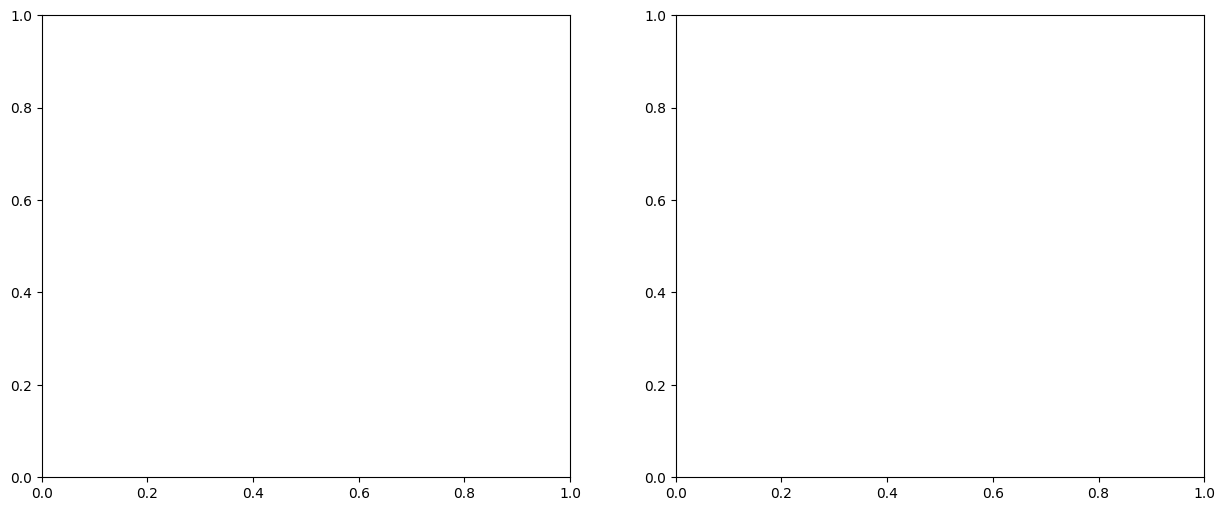

In [22]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(results)
# Criar uma figura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for target in TARGETS:
    subset = results_df[results_df['target'] == target]
    
    # Gráfico 1: RMSE
    ax1.plot(subset['horizon'], subset['rmse'], marker='o', label=target)
    
    # Gráfico 2: MAE
    ax2.plot(subset['horizon'], subset['mae'], marker='s', linestyle='--', label=target)

# Ajustes do gráfico de RMSE
ax1.set_title('Evolução do RMSE por Horizonte')
ax1.set_xlabel('Horizonte (h)')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(True)

# Ajustes do gráfico de MAE
ax2.set_title('Evolução do MAE por Horizonte')
ax2.set_xlabel('Horizonte (h)')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()


In [ ]:
print("\n--- RESUMO DOS RESULTADOS (RMSE) ---")
pivot_rmse = results_df.pivot(index='horizon', columns='target', values='rmse')
display(pivot_rmse.round(4))

print("\n--- RESUMO DOS RESULTADOS (MAE) ---")
pivot_mae = results_df.pivot(index='horizon', columns='target', values='mae')
display(pivot_mae.round(4))

In [ ]:
Retirar u10 e v10

In [15]:
HORIZONS = [1, 3, 6, 12, 24]
LOOKBACK = 48 
TARGETS = ['swh_cop', 'mwp_cop', 'peak_period_cop','swh_era5', 'mwp_era5', 'pp1d_era5']
FEATURES = ['swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop','u10_era5','v10_era5','swh_era5','mwd_era5_sin','mwd_era5_cos','mwp_era5','pp1d_era5']
results = []

for target in TARGETS:
    for h in HORIZONS:

        print(f'\nTreinar target={target} | horizonte={h}h')

        # criar dataset
        X, y = create_supervised_dataset(
            df,
            FEATURES,
            target,
            LOOKBACK,
            h
        )

        X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

        X_train, X_test, scaler = scale_data(X_train, X_test)

        model = build_cnn_model(X_train.shape[1:])

        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=20,
            batch_size=32,
            verbose=2
        )

        y_pred = model.predict(X_test).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)

        print(f'RMSE = {rmse:.3f} | MAE = {mae:.3f}')

        results.append({
            'target': target,
            'horizon': h,
            'rmse': rmse,
            'mae': mae
        })


Treinar target=swh_cop | horizonte=1h
Epoch 1/20
139/139 - 2s - 17ms/step - loss: 1.2137 - mae: 0.7145 - val_loss: 0.1534 - val_mae: 0.3197
Epoch 2/20
139/139 - 1s - 5ms/step - loss: 0.3209 - mae: 0.4013 - val_loss: 0.1908 - val_mae: 0.3761
Epoch 3/20
139/139 - 1s - 4ms/step - loss: 0.2337 - mae: 0.3445 - val_loss: 0.2236 - val_mae: 0.3972
Epoch 4/20
139/139 - 1s - 4ms/step - loss: 0.2344 - mae: 0.3462 - val_loss: 0.1225 - val_mae: 0.2847
Epoch 5/20
139/139 - 1s - 8ms/step - loss: 0.2100 - mae: 0.3234 - val_loss: 0.1402 - val_mae: 0.3107
Epoch 6/20
139/139 - 1s - 5ms/step - loss: 0.1998 - mae: 0.3176 - val_loss: 0.1452 - val_mae: 0.3202
Epoch 7/20
139/139 - 1s - 4ms/step - loss: 0.1802 - mae: 0.3001 - val_loss: 0.1043 - val_mae: 0.2605
Epoch 8/20
139/139 - 1s - 4ms/step - loss: 0.1728 - mae: 0.2946 - val_loss: 0.3130 - val_mae: 0.4757
Epoch 9/20
139/139 - 1s - 4ms/step - loss: 0.1741 - mae: 0.3010 - val_loss: 0.1571 - val_mae: 0.3381
Epoch 10/20
139/139 - 1s - 4ms/step - loss: 0.1686 

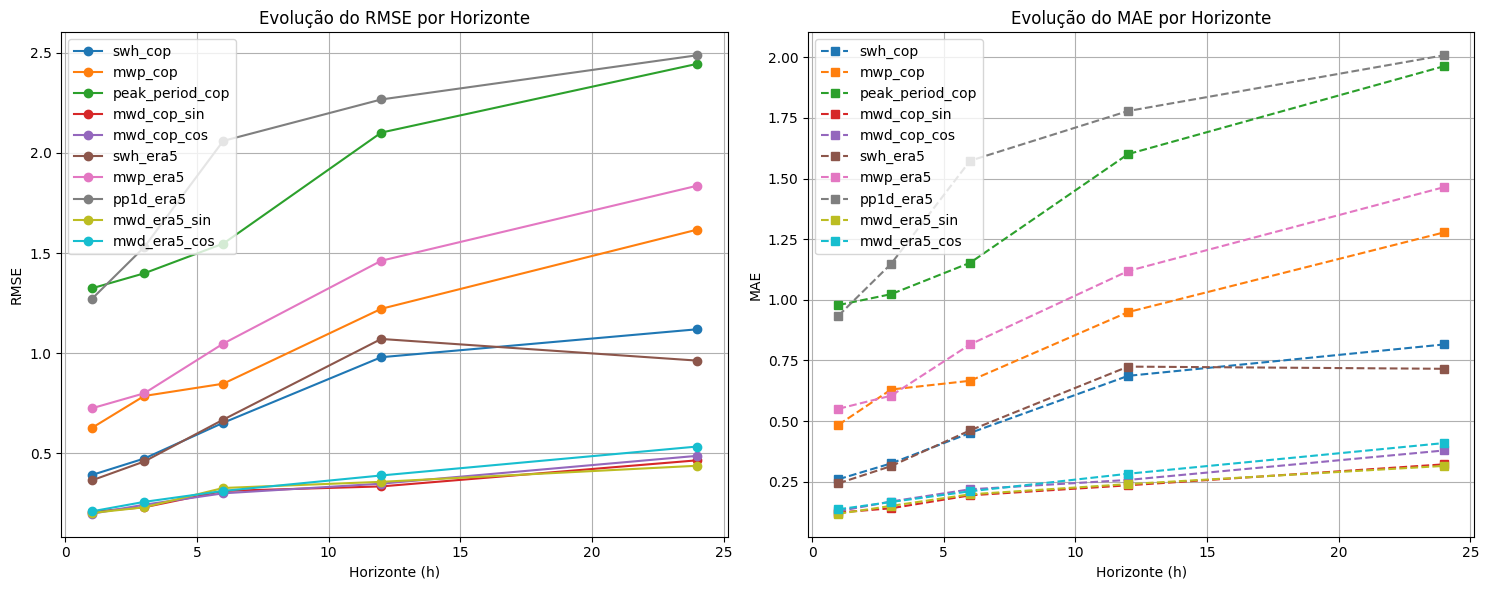

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for target in TARGETS:
    subset = results_df[results_df['target'] == target]
    
    # Gráfico 1: RMSE
    ax1.plot(subset['horizon'], subset['rmse'], marker='o', label=target)
    
    # Gráfico 2: MAE
    ax2.plot(subset['horizon'], subset['mae'], marker='s', linestyle='--', label=target)

# Ajustes do gráfico de RMSE
ax1.set_title('Evolução do RMSE por Horizonte')
ax1.set_xlabel('Horizonte (h)')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(True)

# Ajustes do gráfico de MAE
ax2.set_title('Evolução do MAE por Horizonte')
ax2.set_xlabel('Horizonte (h)')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
print("\n--- RESUMO DOS RESULTADOS (RMSE) ---")
pivot_rmse = results_df.pivot(index='horizon', columns='target', values='rmse')
display(pivot_rmse.round(4))

print("\n--- RESUMO DOS RESULTADOS (MAE) ---")
pivot_mae = results_df.pivot(index='horizon', columns='target', values='mae')
display(pivot_mae.round(4))


--- RESUMO DOS RESULTADOS (RMSE) ---


target,mwd_cop_cos,mwd_cop_sin,mwd_era5_cos,mwd_era5_sin,mwp_cop,mwp_era5,peak_period_cop,pp1d_era5,swh_cop,swh_era5
horizon,,,,,,,,,,
1,0.1978,0.2079,0.2097,0.2018,0.6258,0.7242,1.3233,1.2693,0.3911,0.3642
3,0.2431,0.2302,0.2574,0.2303,0.7862,0.7996,1.3988,1.5296,0.4738,0.4590
6,0.3000,0.3118,0.3120,0.3267,0.8474,1.0477,1.5470,2.0600,0.6524,0.6680
12,0.3483,0.3345,0.3892,0.3575,1.2215,1.4615,2.1015,2.2670,0.9798,1.0709
24,0.4873,0.4649,0.5337,0.4378,1.6170,1.8362,2.4449,2.4877,1.1194,0.9628



--- RESUMO DOS RESULTADOS (MAE) ---


target,mwd_cop_cos,mwd_cop_sin,mwd_era5_cos,mwd_era5_sin,mwp_cop,mwp_era5,peak_period_cop,pp1d_era5,swh_cop,swh_era5
horizon,,,,,,,,,,
1,0.1285,0.1230,0.1363,0.1178,0.4847,0.5508,0.9784,0.9347,0.2602,0.2435
3,0.1685,0.1405,0.1666,0.1505,0.6303,0.6049,1.0234,1.1486,0.3257,0.3145
6,0.2188,0.1940,0.2107,0.1982,0.6663,0.8161,1.1528,1.5735,0.4511,0.4619
12,0.2574,0.2353,0.2830,0.2402,0.9494,1.1188,1.6009,1.7785,0.6867,0.7247
24,0.3790,0.3218,0.4095,0.3153,1.2781,1.4647,1.9634,2.0084,0.8161,0.7157
